# AI Project 3 (Part 1.4)

Leena Dighole

In [3]:
#import files
import numpy as np
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import itertools
import random
from statistics import mean

In [4]:
class landscape_environment(object):
    
    """
    1.Create the map with given dim value
    2.Create the landscape environment with given 4 types of terrain:
        i) Hilly : p = 0.3
        ii) Flat : p = 0.2
        iii)Forested: p = 0.3
        iv) Cave : p = 0.2
    3.Target is hidden inside one of the cell in the landscape
    
    """
    def __init__(self,d):  #Initialization function
        self.dim = int(d)
        self.maze =None
        self.target =None
        self.round_count = 0
        self.neighbors = []  #neighbor storing array
        self.matrix =[]  #neighbor probability storing array
    
        
    def get_terrain(self,cell):
        """
        Given the cell index, this will return the terrain of the cell.
        Note we have this information in out map about the cells and its correspondig terrain
        """     
        i,j = cell
        if self.map[i][j] == 0:
            self.cell_terrain = 'Flat'
            self.cell_FN = 0.1
        elif self.map[i][j] == 1:
            self.cell_terrain = 'Hilly'
            self.cell_FN = 0.3
        elif self.map[i][j] == 2:
            self.cell_terrain = 'Forested'
            self.cell_FN = 0.7
        elif self.map[i][j] == 3:
            self.cell_terrain = 'Cave'
            self.cell_FN = 0.9
       # print('The terrain of cell ',cell,'is :',self.cell_terrain)
        return self.cell_terrain ,self.cell_FN
    
    def create_landscape(self,d):
        """
        Terrain and corersponding value on the map
        Terrain       Probability        Value on map   color on map
        1)Flat :      0.2                 0             White
        2)Hilly :     0.3                 1             very light green
        3)Forested :  0.3                 2             light green
        4)Cave :      0.2                 3             Dark green
        
        """
        self.d = int(d)
        #Create the landscape with given probabilities of different terrains
        self.map = np.random.choice([0,1,2,3],(self.d,self.d),p=[0.2,0.3,0.3,0.2])
        
        
        #Choose the Target node randomly
        i = np.random.choice(self.d)
        j = np.random.choice(self.d)
        self.target = (i,j)
        self.target_terrain = self.get_terrain(self.target)
        #self.map[i][i]=5
        #Print the start node and its terrain
        print('The map values can be represented as:\n',self.map)
        print('The Target node is:\n ',self.target,'The terrain is:',self.target_terrain)
        
        return self.map,self.target
    
    def print_landscape(self,maze,target):
        """
        Print the 2-D landscape with different terrains along with the randomly located target
        Terrain     Color on map
        1)Flat       white
        2)Hilly      very light Green
        3)Forested   Light Green
        4)Cave       Dark Green
        
        """
        fig = plt.figure(figsize = (10,10))
        ax = fig.add_subplot(111)

        ax.pcolormesh(maze, cmap='Greens', zorder=1) 
        ax.grid(True, color="black", lw=1)           

        ticks = range(0, maze.shape[0])
        #print('ticks',ticks)
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        
        #Locate Target with red cross sign
        i,j = target
        ax.plot([j,j+1],[i,i+1],lw=4,color = 'red')
        ax.plot([j,j+1],[i+1,i],lw=4,color = 'red')

        ax.set_aspect('equal')
        ax.invert_yaxis()

        plt.style.use('ggplot')
        plt.rcParams["axes.axisbelow"] = False  # Force grid to be on top: caused due to 'ggplot' style
        plt.show()
    
    def search_cell(self,cell):  #Searching the target in given cell and provide search results
        self.cell = cell
        self.cell_terrain,self.cell_FN = self.get_terrain(self.cell)
        self.round_count+=1
        self.previous_search = self.cell
        #Search the cell
        if self.cell != self.target:  #if search is taking place outside target cell
            self.cell_search_result = 0  #Failure
            
        elif self.cell == self.target: #if search is taking place in a target cell
            self.cell_search_result = np.random.choice([0,1],p = [self.cell_FN, 1-self.cell_FN])
                
        return self.cell_search_result
    
    def update_belief_matrix(self,update,previous_search):
        '''
        Create initial target belief matrix
        for 10*10 matrix, the probability that the target is in each cell initially will be 1/100
        P(Target in cell i) = Bt(i)
        The P(target found in cell i) = (1-FN)*P(Target in cell i)
        
        If we get failure in searching cell j then we need to update our belief regarding Bt(i)
        P(Target in cell i) = Bt(i)*P(fail j/in i,observations t)/P(fail j/Observations t)
        P(fail j/Observations t) = (Bt(j)*FN) + (1-Bt(j))*1                
        
        '''
       
        if update == 0:  #initial round
            self.target_matrix = np.ones((self.d,self.d))/(self.d*self.d)  #initial target matrix
            #print('The Target initial matrix is\n',self.target_matrix )
        elif update==1:  #update Target belief matrix
            
            #calculate P(Fail in cell/Observations_t) = P(target in failed cell )*FN + (1-P( target in failed cell))*1
            self.previous_failure_cell = previous_search
            fail_cell_terrain,fail_cell_FN = self.get_terrain(self.previous_failure_cell)
            fail_i, fail_j =self.previous_failure_cell
            Bt_fail = self.target_matrix[fail_i][fail_j]
            self.P_fail = (Bt_fail *fail_cell_FN ) + (1-Bt_fail)  #denominator term of updating target matrix
         
            
            for i in range(self.d):
                for j in range(self.d):
                    current_cell = (i,j)
                    current_cell_terrain,cell_FN = self.get_terrain(current_cell)
                    if current_cell == self.previous_failure_cell:
                        self.target_matrix[i][j] = (self.target_matrix[i][j]*cell_FN)/self.P_fail
                    else:
                        self.target_matrix[i][j] = (self.target_matrix[i][j])/self.P_fail
           # print('The Updated Target initial matrix is\n',self.target_matrix )
        
        #create initial Target found matrix
        #P(Target found in the cell i) = P(Target in cell i) *(1-False Negative rate)
        self.found_matrix =  np.copy(self.target_matrix)
        for i in range(self.d):
            for j in range(self.d):
                current_cell = (i,j)
                current_cell_terrain,cell_FN = self.get_terrain(current_cell)
                self.found_matrix [i][j] = (1-cell_FN) *self.found_matrix[i][j]
        #print('The target found initial matrix is\n',self.found_matrix )
        
        #Sanity check
        #The addition of all elements in target matrix should add up to 1
        #The found matrix wont add up to 1 but target matrix does
        #print('The sum of target matrix is',np.sum(self.target_matrix).round(3))
        #print('The sum of found matrix is',np.sum(self.found_matrix).round(3))
            
        return self.target_matrix, self.found_matrix
    
    def get_neighbors(self,cell):
        #Get the up,down, left and right cells of the given cell
        i,j = cell
        self.neighbors =[]
        if 0<=i<self.dim  and 0<=j<self.dim:
            if i-1>= 0:  
                self.neighbors.append((i-1,j))  #up cell
            if i+1< self.dim:
                self.neighbors.append((i+1,j))  #down cell
            if j-1>=0 :
                self.neighbors.append((i,j-1))  #left cell
            if j+1< self.dim:
                self.neighbors.append((i,j+1))  #right cell
        #print('The current neighbors of ',self.previous_search,'are:\n',self.neighbors)
        return self.neighbors
    
    def get_neighbors_improved_agent(self,cell):
        #Get the up,down, left and right cells of the given cell
        i,j = cell
        self.neighbors_1 =[]
        self.neighbors_2 =[]
        self.neighbors_3 =[]
        if 0<=i<self.dim  and 0<=j<self.dim:
            if i-1>= 0:  
                self.neighbors_1.append((i-1,j))  #up cell
            if i+1< self.dim:
                self.neighbors_1.append((i+1,j))  #down cell
            if j-1>=0 :
                self.neighbors_1.append((i,j-1))  #left cell
            if j+1< self.dim:
                self.neighbors_1.append((i,j+1))  #right cell
            if i-2>= 0:  
                self.neighbors_2.append((i-2,j))  #up 2 nd cell
            if i+2< self.dim:
                self.neighbors_2.append((i+2,j))  #down 2 nd cell
            if j-2>=0 :
                self.neighbors_2.append((i,j-2))  #left 2 nd cell
            if j+2< self.dim:
                self.neighbors_2.append((i,j+2))  #right 2 nd cell
            if i-3>= 0:  
                self.neighbors_3.append((i-3,j))  #up 3 rd cell
            if i+3< self.dim:
                self.neighbors_3.append((i+3,j))  #down 3 rd cell
            if j-3>=0 :
                self.neighbors_3.append((i,j-3))  #left 3 rd cell
            if j+3< self.dim:
                self.neighbors_3.append((i,j+3))  #right 3 rd cell
            
        #print('The current neighbors of ',self.previous_search,'are:\n',self.neighbors)
        #print('self.neighbors_1',self.neighbors_1)
       # print('self.neighbors_2',self.neighbors_2)
      #  print('self.neighbors_3',self.neighbors_3)
        return self.neighbors_1,self.neighbors_2,self.neighbors_3
    
    def Rule_1_search(self,target_matrix):
        '''
        Search the cell with highest probability of containing the target
        '''

        self.matrix1 = target_matrix
        '''
        self.max_val = np.amax(self.matrix1)
        self.max_val_loc_i,self.max_val_loc_j = np.where(self.matrix1 == self.max_val)
        print('The max value using rule 1 is:',self.max_val)
        print('The max value location is:',self.max_val_loc_i,'\n j ',self.max_val_loc_j )
        
        if len(self.max_val_loc_i) >1:
            index = np.random(len(self.max_val_loc_i))
            self.max_val_loc_i = self.max_val_loc_i[index]
            self.max_val_loc_j = self.max_val_loc_j[index]
        self.next_cell = (self.max_val_loc_i,self.max_val_loc_j)
        '''
        self.current_neighbors =self.get_neighbors(self.previous_search)
        self.current_neighbors.append(self.previous_search)
        self.matrix =[]
        #print('self.matrix 1',self.matrix1)
        for cell in self.current_neighbors:
            self.row,self.col = cell
            self.matrix.append(self.matrix1[self.row][self.col])
            #continue
           
        #ind = np.unravel_index(np.argmax( self.matrix, axis=None),  self.matrix.shape)
        #print('self.matrix ',self.matrix)
        
        #ind1 = np.where(self.matrix == (np.amax(self.matrix)))
        #print('ind1',ind1)
        ind = np.argmax(self.matrix)
        #print('ind',ind)
        self.next_cell = self.current_neighbors[ind]
        #print('The next cell to be searched using Rule 1 is:',self.next_cell)
        return self.next_cell
    
    def Rule_2_search(self,found_matrix):
        '''
        Search the cell with highest probability of finding the target
        '''
        self.matrix1 = found_matrix
        self.current_neighbors =self.get_neighbors(self.previous_search)
        self.current_neighbors.append(self.previous_search)
        self.matrix =[]
        #print('self.matrix 1',self.matrix1)
        for cell in self.current_neighbors:
            self.row,self.col = cell
            self.matrix.append(self.matrix1[self.row][self.col])
        
        #i,j = self.previous_search
        #self.matrix.append(self.matrix1[i][j]) 
 
        ind = np.argmax(self.matrix)
        #print('ind',ind)
        self.next_cell = self.current_neighbors[ind]
        #print('The next cell to be searched using Rule 1 is:',self.next_cell)
        return self.next_cell
    
    def Rule_3_search(self,found_matrix):
        '''
        Aim: Search the cell with lowest score
        score = manhatten distance from current location/ probability of finding target in that cell
        lowest score=> search the neighbor cell
        
        '''
        self.matrix1 = found_matrix
        self.current_neighbors =self.get_neighbors(self.previous_search)
        #self.current_neighbors =[]
        self.matrix =[]
        #print('self.matrix 1',self.matrix1)
        
     
        for cell in self.current_neighbors:
            self.row,self.col = cell
            self.matrix.append(1/self.matrix1[self.row][self.col])
        ind = np.argmin(self.matrix)
        '''
        ii,jj = self.previous_search
        self.distance =[]
        for i in range(self.dim):
            for j in range(self.dim):
                current_cell = (i,j)
                self.current_neighbors.append(current_cell)
                t = np.subtract(current_cell,self.previous_search)
                tt = abs(t[0])+abs(t[1])
                self.distance.append(tt)
                self.matrix.append(tt/self.matrix1[i][j])
        #print('self.matrix',self.matrix)
      '''
            
        ind = np.argmin(self.matrix)
        #print('ind',ind)
        self.next_cell = self.current_neighbors[ind]
        #print('The next cell to be searched using Rule 1 is:',self.next_cell)
        return self.next_cell
    
    def Rule_4_search(self,found_matrix):
        '''
        Aim: Search the cell with lowest score
        score = manhatten distance from current location/ probability of finding target in that cell
        lowest score=> search the neighbor cell
        To do:
        Search the score for next 5 levels of the neighbors and search the neighbor cell with the average low score.
        
        '''
        self.matrix1 = found_matrix
        self.current_neighbors_1,self.current_neighbors_2,self.current_neighbors_3 =self.get_neighbors_improved_agent(self.previous_search)
        #print('self.matrix 1',self.matrix1)
        
        #calculating score for immediate neighbors
        self.matrix_level_1 =[]
        for cell in self.current_neighbors_1:
            self.row,self.col = cell
            self.matrix_level_1.append(1/self.matrix1[self.row][self.col])
        
        #calculating score for second level neighbors
        self.matrix_level_2 =[]
        for cell in self.current_neighbors_2:
            self.row,self.col = cell
            self.matrix_level_2.append(2/self.matrix1[self.row][self.col])
                
        #calculating score for third level neighbors
        self.matrix_level_3 =[]
        for cell in self.current_neighbors_3:
            self.row,self.col = cell
            self.matrix_level_3.append(3/self.matrix1[self.row][self.col])
        
        self.up =[]
        self.down =[]
        self.left =[]
        self.right =[]
        
        #for i in range(len(self.matrix_level_1)):
            
        if  (len(self.matrix_level_1)>=1):
            self.up.append(self.matrix_level_1[0])
        if (len(self.matrix_level_2)>=1):   
            self.up.append(self.matrix_level_2[0])
        if (len(self.matrix_level_3)>=1):   
            self.up.append(self.matrix_level_3[0])
        if (len(self.matrix_level_1)>=2):
            self.down.append(self.matrix_level_1[1])
        if (len(self.matrix_level_2)>=2):   
            self.down.append(self.matrix_level_2[1])
        if (len(self.matrix_level_3) >=2):   
            self.down.append(self.matrix_level_3[1])
        if (len(self.matrix_level_1)>=3):
            self.left.append(self.matrix_level_1[2])
        if (len(self.matrix_level_2)>=3):   
            self.left.append(self.matrix_level_2[2])
        if (len(self.matrix_level_3)>=3):   
            self.left.append(self.matrix_level_3[2])
        if (len(self.matrix_level_1)>=4):
            self.right.append(self.matrix_level_1[3])
        if (len(self.matrix_level_2)>=4):   
            self.right.append(self.matrix_level_2[3])
        if (len(self.matrix_level_3)>=4):   
            self.right.append(self.matrix_level_3[3])
   
        if (len(self.up)>=1):
            self.up = np.mean(self.up)
        if (len(self.down)>=1):
            self.down = np.mean(self.down)
        if (len(self.left)>=1):
            self.left = np.mean(self.left)
        if (len(self.right)>=1):
            self.right = np.mean(self.right)

        
        self.matrix =[self.up,self.down,self.left,self.right]
        ind = np.argmin(self.matrix)
        #print('ind',ind)
        self.next_cell = self.current_neighbors_1[ind]
        #print('The next cell to be searched using Rule 1 is:',self.next_cell)
        return self.next_cell
    
    def start_search(self,d):
        i = np.random.choice(self.d)
        j = np.random.choice(self.d)
        self.start = (i,j)
        print('The initial node is:',self.start)
        self.cell_search_result = self.search_cell(self.start)
        return self.cell_search_result
        
        
    def first_search_Rule_1(self,d):
        
        self.cell_search_result = self.start_search(d)
        #self.previous_search = self.start
        if self.round_count ==1:  #initial belief
            update = 0
        elif self.round_count >1:
            update = 1
        #Update belief
        self.target_matrix,self.found_matrix = self.update_belief_matrix(update,self.previous_search)
        
        if self.cell_search_result == 1: #Success in searching
            print('Hurray! The target is found!!\n in',self.round_count, 'steps')
        elif self.cell_search_result == 0: #Failure in searching
            print('Update belief matrix')
            update = 1
            #We need to update our belief knowing we got failure in previous search
            self.target_matrix,self.found_matrix = self.update_belief_matrix(update,self.previous_search)
            self.next_cell = self.Rule_1_search(self.target_matrix)
            
        while (self.cell_search_result !=1):
            self.cell_search_result = self.search_cell(self.next_cell)
            #update = 1
            #We need to update our belief knowing we got failure in previous search
            self.target_matrix,self.found_matrix = self.update_belief_matrix(update,self.previous_search)
            self.next_cell = self.Rule_1_search(self.target_matrix)
            continue
        if self.cell_search_result == 1: #Success in searching
            print('Hurray! The target is found!!\n in',self.round_count, 'steps')
        return self.round_count
            
    def first_search_Rule_2(self,d):
        self.cell_search_result = self.start_search(d)
        #self.previous_search = self.start
        if self.round_count ==1:  #initial belief
            update = 0
        elif self.round_count >1:
            update = 1
        #Update belief
        self.target_matrix,self.found_matrix = self.update_belief_matrix(update,self.previous_search)
        
        if self.cell_search_result == 1: #Success in searching
            print('Hurray! The target is found!!\n in',self.round_count, 'steps')
        elif self.cell_search_result == 0: #Failure in searching
            print('Update belief matrix')
            update = 1
            #We need to update our belief knowing we got failure in previous search
            self.target_matrix,self.found_matrix = self.update_belief_matrix(update,self.previous_search)
            self.next_cell = self.Rule_2_search(self.found_matrix)
            
        while (self.cell_search_result !=1):
            self.cell_search_result = self.search_cell(self.next_cell)
            #update = 1
            #We need to update our belief knowing we got failure in previous search
            self.target_matrix,self.found_matrix = self.update_belief_matrix(update,self.previous_search)
            self.next_cell = self.Rule_2_search(self.found_matrix)
            continue
        if self.cell_search_result == 1: #Success in searching
            print('Hurray! The target is found!!\n in',self.round_count, 'steps')
        return self.round_count
    
    def first_search_Rule_3(self,d):
        '''
        Aim: Search the cell with lowest score
        score = manhatten distance from current location/ probability of finding target in that cell
        lowest score=> search the neighbor cell
        '''
        self.cell_search_result = self.start_search(d)
        #self.previous_search = self.start
        if self.round_count ==1:  #initial belief
            update = 0
        elif self.round_count >1:
            update = 1
        #Update belief
        self.target_matrix,self.found_matrix = self.update_belief_matrix(update,self.previous_search)
        
        if self.cell_search_result == 1: #Success in searching
            print('Hurray! The target is found!!\n in',self.round_count, 'steps')
        elif self.cell_search_result == 0: #Failure in searching
            print('Update belief matrix')
            update = 1
            #We need to update our belief knowing we got failure in previous search
            self.target_matrix,self.found_matrix = self.update_belief_matrix(update,self.previous_search)
            self.next_cell = self.Rule_3_search(self.found_matrix)
            
        while (self.cell_search_result !=1):
            self.cell_search_result = self.search_cell(self.next_cell)
            #update = 1
            #We need to update our belief knowing we got failure in previous search
            self.target_matrix,self.found_matrix = self.update_belief_matrix(update,self.previous_search)
            self.next_cell = self.Rule_3_search(self.found_matrix)
            continue
        if self.cell_search_result == 1: #Success in searching
            print('Hurray! The target is found!!\n in',self.round_count, 'steps')
        return self.round_count
    
    def first_search_Rule_4(self,d):
        '''
        Aim: Search the cell with lowest score
        score = manhatten distance from current location/ probability of finding target in that cell
        lowest score=> search the neighbor cell
        To do:
        Search the score for next 5 levels of the neighbors and search the neighbor cell with the average low score.
        '''
        self.cell_search_result = self.start_search(d)
        #self.previous_search = self.start
        if self.round_count ==1:  #initial belief
            update = 0
        elif self.round_count >1:
            update = 1
        #Update belief
        self.target_matrix,self.found_matrix = self.update_belief_matrix(update,self.previous_search)
        
        if self.cell_search_result == 1: #Success in searching
            print('Hurray! The target is found!!\n in',self.round_count, 'steps')
        elif self.cell_search_result == 0: #Failure in searching
            print('Update belief matrix')
            update = 1
            #We need to update our belief knowing we got failure in previous search
            self.target_matrix,self.found_matrix = self.update_belief_matrix(update,self.previous_search)
            self.next_cell = self.Rule_4_search(self.found_matrix)
            
        while (self.cell_search_result !=1):
            self.cell_search_result = self.search_cell(self.next_cell)
            #update = 1
            #We need to update our belief knowing we got failure in previous search
            self.target_matrix,self.found_matrix = self.update_belief_matrix(update,self.previous_search)
            self.next_cell = self.Rule_4_search(self.found_matrix)
            continue
        if self.cell_search_result == 1: #Success in searching
            print('Hurray! The target is found!!\n in',self.round_count, 'steps')
        return self.round_count
            
        
    def start_searching_rule1(self,d):
        """
        1.Create landscape with given terrains and respective probabilities
        2.Print the board and locate the target node
        3. Search the map with rule 1: 
         At any time, search the cell with the highest probability of containing the target

        """
        self.maze,self.target = self. create_landscape(d) 
        self.print_landscape(self.maze,self.target)
        self.final_result = self.first_search_Rule_1(d)
        return self.final_result
       
    
    def start_searching_rule2(self,d):
        """
        1.Create landscape with given terrains and respective probabilities
        2.Print the board and locate the target node
        3. Search the map with rule 2: 
         At any time, search the cell with the highest probability of finding the target

        """
        self.maze,self.target = self. create_landscape(d) 
        self.print_landscape(self.maze,self.target)
        self.final_result =self.first_search_Rule_2(d)
        return self.final_result
    
    def start_searching_rule3(self,d):
        """
        1.Create landscape with given terrains and respective probabilities
        2.Print the board and locate the target node
        3.Search the map with rule 3: 
        Aim: Search the cell with lowest score
        score = manhatten distance from current location/ probability of finding target in that cell
        lowest score=> search the neighbor cell

        """
        self.maze,self.target = self. create_landscape(d) 
        self.print_landscape(self.maze,self.target)
        self.final_result =self.first_search_Rule_3(d)
        return self.final_result
    
    def start_searching_rule4(self,d):
        """
        1.Create landscape with given terrains and respective probabilities
        2.Print the board and locate the target node
        3.Search the map with rule 4: 
        Aim: Search the cell with lowest score with neighboring 
        score = manhatten distance from current location/ probability of finding target in that cell
        lowest score=> search the neighbor cell
        """
        self.maze,self.target = self. create_landscape(d) 
        self.print_landscape(self.maze,self.target)
        self.final_result =self.first_search_Rule_4(d)
        return self.final_result

    
    

Enter the size of dimension of the minesweeper d :50
The map values can be represented as:
 [[1 0 1 ... 0 0 2]
 [1 1 3 ... 1 2 1]
 [0 1 0 ... 1 0 2]
 ...
 [2 1 2 ... 3 1 0]
 [3 1 1 ... 1 1 2]
 [1 3 2 ... 2 0 0]]
The Target node is:
  (47, 14) The terrain is: ('Cave', 0.9)


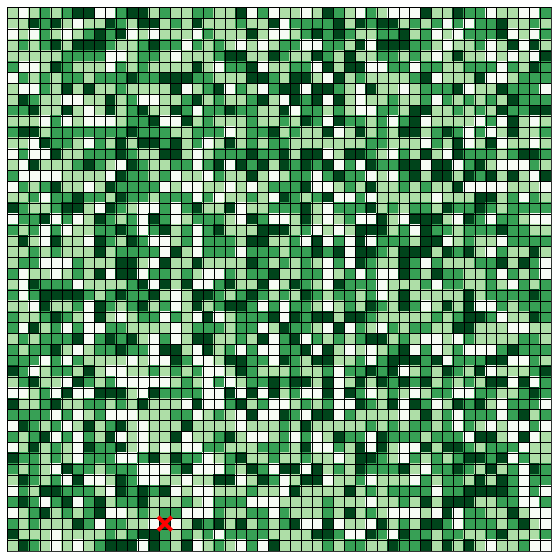

The initial node is: (32, 44)
Update belief matrix
Hurray! The target is found!!
 in 17544 steps


17544

In [5]:
#Agent 1
d = input('Enter the size of dimension of the minesweeper d :') 
obj1 = landscape_environment(d)
obj1.start_searching_rule1(d)

Enter the size of dimension of the minesweeper d :50
The map values can be represented as:
 [[1 3 2 ... 1 0 0]
 [0 2 1 ... 2 1 2]
 [0 2 3 ... 2 0 3]
 ...
 [3 2 0 ... 1 2 1]
 [0 3 0 ... 0 2 3]
 [1 2 1 ... 0 1 2]]
The Target node is:
  (18, 46) The terrain is: ('Cave', 0.9)


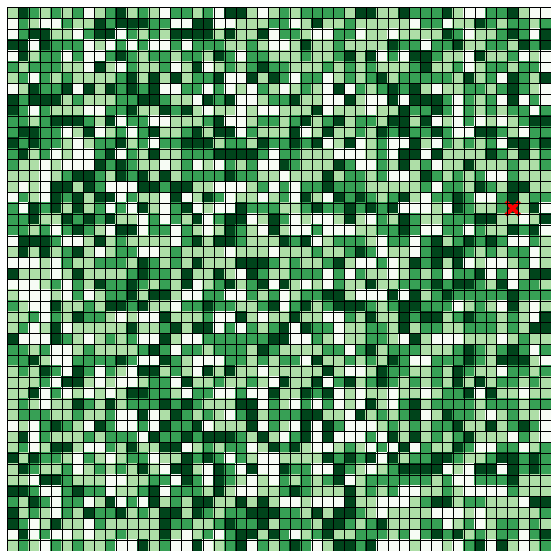

The initial node is: (45, 12)
Update belief matrix
Hurray! The target is found!!
 in 34430 steps


34430

In [6]:
#Agent 2
d = input('Enter the size of dimension of the minesweeper d :') 
obj2 = landscape_environment(d)
obj2.start_searching_rule2(d)

Enter the size of dimension of the minesweeper d :50
The map values can be represented as:
 [[1 3 2 ... 2 3 1]
 [1 1 1 ... 2 2 1]
 [0 0 2 ... 0 0 1]
 ...
 [2 2 1 ... 2 0 0]
 [1 1 3 ... 1 3 0]
 [0 1 2 ... 1 3 1]]
The Target node is:
  (33, 20) The terrain is: ('Flat', 0.1)


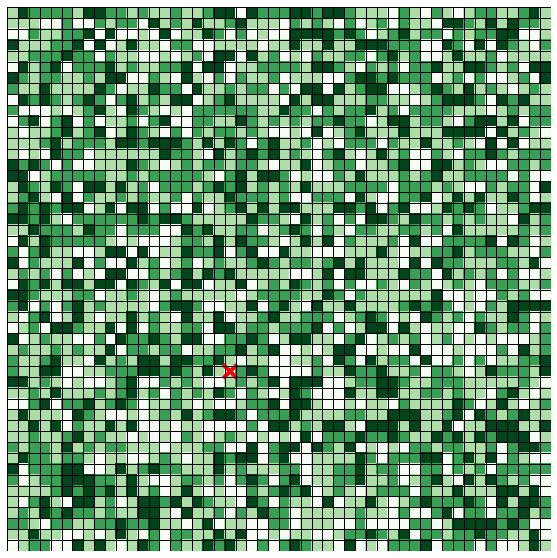

The initial node is: (4, 37)
Update belief matrix
Hurray! The target is found!!
 in 615 steps


615

In [7]:
#Agent 3
d = input('Enter the size of dimension of the minesweeper d :') 
obj3 = landscape_environment(d)
obj3.start_searching_rule3(d)

Enter the size of dimension of the minesweeper d :50
The map values can be represented as:
 [[1 3 1 ... 3 3 0]
 [0 3 0 ... 1 0 2]
 [2 0 2 ... 2 2 1]
 ...
 [2 0 2 ... 1 0 2]
 [2 2 0 ... 1 2 0]
 [2 2 2 ... 2 2 0]]
The Target node is:
  (39, 37) The terrain is: ('Hilly', 0.3)


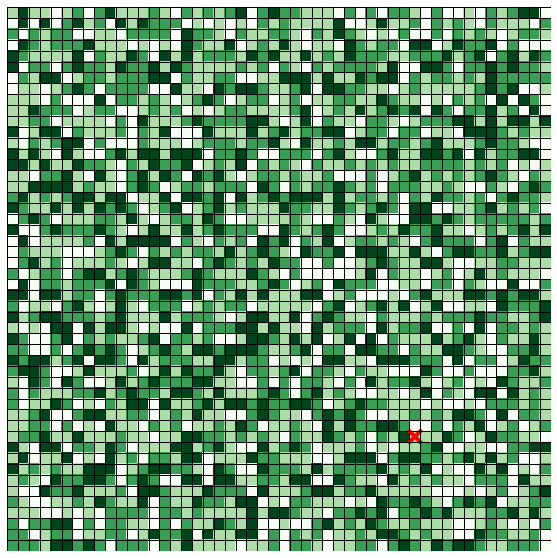

The initial node is: (38, 36)
Update belief matrix
Hurray! The target is found!!
 in 461 steps


461

In [8]:
#Agent 4
d = input('Enter the size of dimension of the minesweeper d :') 
obj4 = landscape_environment(d)
obj4.start_searching_rule4(d)

In [ ]:
#Rule 1

d = input('Enter the size of dimension of the minesweeper d :')   
#Calculating average no of rounds using Rule 1
rounds_array =[]
n =0
while (n != 50):   
    obj1 = landscape_environment(d)
    count = obj1.start_searching_rule1(d)
    rounds_array.append(count)
    n += 1
    print(n+1)
print('for d',d,'rounds_array',rounds_array)
average_rounds = np.mean(rounds_array)
print('The average final rounds using rule 1 is:',average_rounds)



In [ ]:
#Rule 2
d = input('Enter the size of dimension of the minesweeper d :')   
#Calculating average no of rounds using Rule 1
rounds_array =[]
n =0
while (n != 50):   
    obj2 = landscape_environment(d)
    count = obj2.start_searching_rule2(d)
    rounds_array.append(count)
    n += 1
    print(n+1)
print('for d',d,'rounds_array',rounds_array)
average_rounds = np.mean(rounds_array)
print('The average final rounds using rule 2 is:',average_rounds)



In [ ]:
#Rule 3
d = input('Enter the size of dimension of the minesweeper d :')   
#Calculating average no of rounds using Rule 1
rounds_array =[]
n =0
while (n != 50):   
    obj3 = landscape_environment(d)
    count = obj3.start_searching_rule3(d)
    rounds_array.append(count)
    n += 1
    print(n+1)
print('for d',d,'rounds_array',rounds_array)
average_rounds = np.mean(rounds_array)
print('The average final rounds using rule 3 is:',average_rounds)



In [ ]:
#Rule 4

d = input('Enter the size of dimension of the minesweeper d :')   
#Calculating average no of rounds using Rule 1
rounds_array =[]
n =0
while (n != 50):   
    obj4 = landscape_environment(d)
    count = obj4.start_searching_rule4(d)
    rounds_array.append(count)
    n += 1
    print(n+1)
print('for d',d,'rounds_array',rounds_array)
average_rounds = np.mean(rounds_array)
print('The average final rounds using rule 1 is:',average_rounds)

